In [3]:
import pandas as pd

df = pd.read_csv("dataset/Resume/Resume.csv")

Data Exploration and Preprocessing:


[nltk_data] Downloading package stopwords to /home/pias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/pias/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  

Category Distribution:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF  

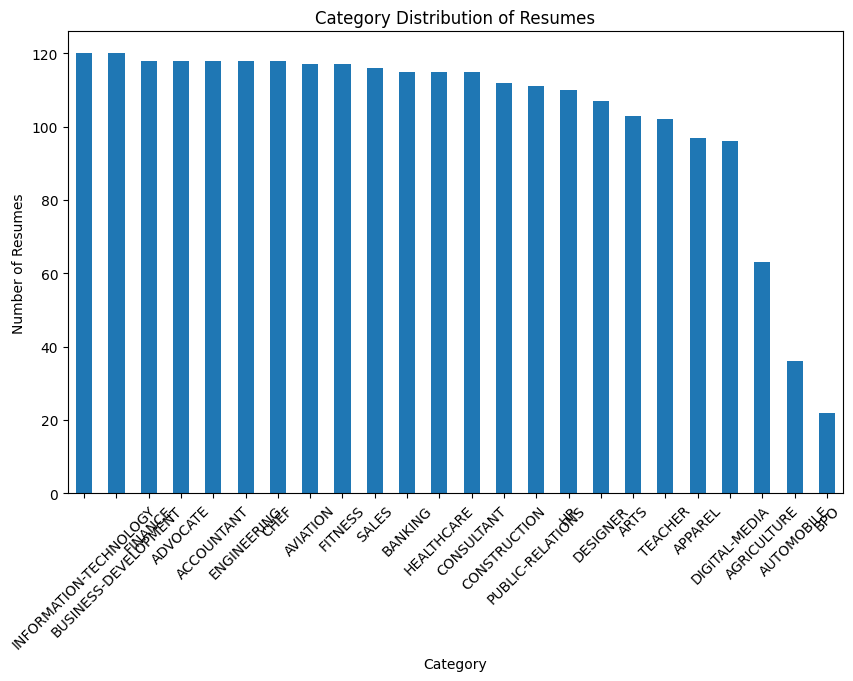

Training set size: 1738
Validation set size: 373
Test set size: 373


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import joblib

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text 
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text

# Load the dataset
df = pd.read_csv("dataset/Resume/Resume.csv")

# Display the first few rows of the dataset
print(df.head())

# Get the distribution of categories
category_distribution = df['Category'].value_counts()

# Print the distribution of categories
print("\nCategory Distribution:")
print(category_distribution)

# Plot the distribution of categories
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar')
plt.title('Category Distribution of Resumes')
plt.xlabel('Category')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45)
plt.show()

# Preprocess the 'Resume_str' column
df['Resume_str'] = df['Resume_str'].apply(preprocess_text)

# Tokenization
max_words = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Resume_str'])


# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['Resume_str'])

# Padding the sequences 
max_len = 200  # Maximum length of sequences 
X = pad_sequences(sequences, maxlen=max_len)

# Convert category labels to numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

category_values = df['Category'].values
label_map = {label: idx for idx, label in enumerate(np.unique(category_values))}

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Save the tokenizer and label encoder and label map
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

with open('label_map.pkl', 'wb') as f:
    joblib.dump(label_map, f)

Model Selection and Training:

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Model Parameters
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
num_classes = len(label_encoder.classes_)

# Build the model
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
model.add(Dropout(dropout_rate))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


2024-08-22 23:02:36.148558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 23:02:36.151567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 23:02:36.153523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 1,388,632
Trainable params: 1,388,632
Non-trainable params: 0
______________________________________________

2024-08-22 23:02:36.351250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-08-22 23:02:36.434010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 23:02:36.435903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [3]:
# Set training parameters
batch_size = 32
epochs = 100

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

# Save the trained model
model.save('resume_classification_model.h5')

Epoch 1/100


2024-08-22 23:02:57.554736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 23:02:57.557583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 23:02:57.560132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/55 [==============================] - ETA: 0s - loss: 3.1700 - accuracy: 0.0547

2024-08-22 23:03:11.517517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 23:03:11.520457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 23:03:11.523083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/55 [==============================] - 15s 193ms/step - loss: 3.1700 - accuracy: 0.0547 - val_loss: 3.1616 - val_accuracy: 0.0295
Epoch 2/100
55/55 [==============================] - 10s 176ms/step - loss: 3.0757 - accuracy: 0.1128 - val_loss: 3.0820 - val_accuracy: 0.0617
Epoch 3/100
55/55 [==============================] - 9s 166ms/step - loss: 2.7532 - accuracy: 0.1974 - val_loss: 2.7867 - val_accuracy: 0.1850
Epoch 4/100
55/55 [==============================] - 9s 165ms/step - loss: 2.2042 - accuracy: 0.3636 - val_loss: 2.7948 - val_accuracy: 0.1984
Epoch 5/100
55/55 [==============================] - 10s 189ms/step - loss: 1.6968 - accuracy: 0.5092 - val_loss: 2.7304 - val_accuracy: 0.2493
Epoch 6/100
55/55 [==============================] - 10s 173ms/step - loss: 1.1820 - accuracy: 0.6542 - val_loss: 3.0649 - val_accuracy: 0.2252
Epoch 7/100
55/55 [==============================] - 9s 165ms/step - loss: 0.8026 - accuracy: 0.7773 - val_loss: 3.1654 - val_accuracy: 0.2466
Epoch 8

In [17]:
#Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Validation Loss: 3.1345112323760986
Validation Accuracy: 0.13672922551631927


2024-08-22 22:46:16.750112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 22:46:16.753350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 22:46:16.755760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 38ms/step

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.15      0.69      0.24        16
              ADVOCATE       0.00      0.00      0.00         9
           AGRICULTURE       0.00      0.00      0.00         6
               APPAREL       0.00      0.00      0.00        18
                  ARTS       0.00      0.00      0.00        17
            AUTOMOBILE       0.00      0.00      0.00         3
              AVIATION       0.00      0.00      0.00        17
               BANKING       0.00      0.00      0.00        16
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.00      0.00      0.00        13
                  CHEF       0.00      0.00      0.00        20
          CONSTRUCTION       0.00      0.00      0.00        28
            CONSULTANT       0.00      0.00      0.00        25
              DESIGNER   

/home/pias/work/work_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pias/work/work_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pias/work/work_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


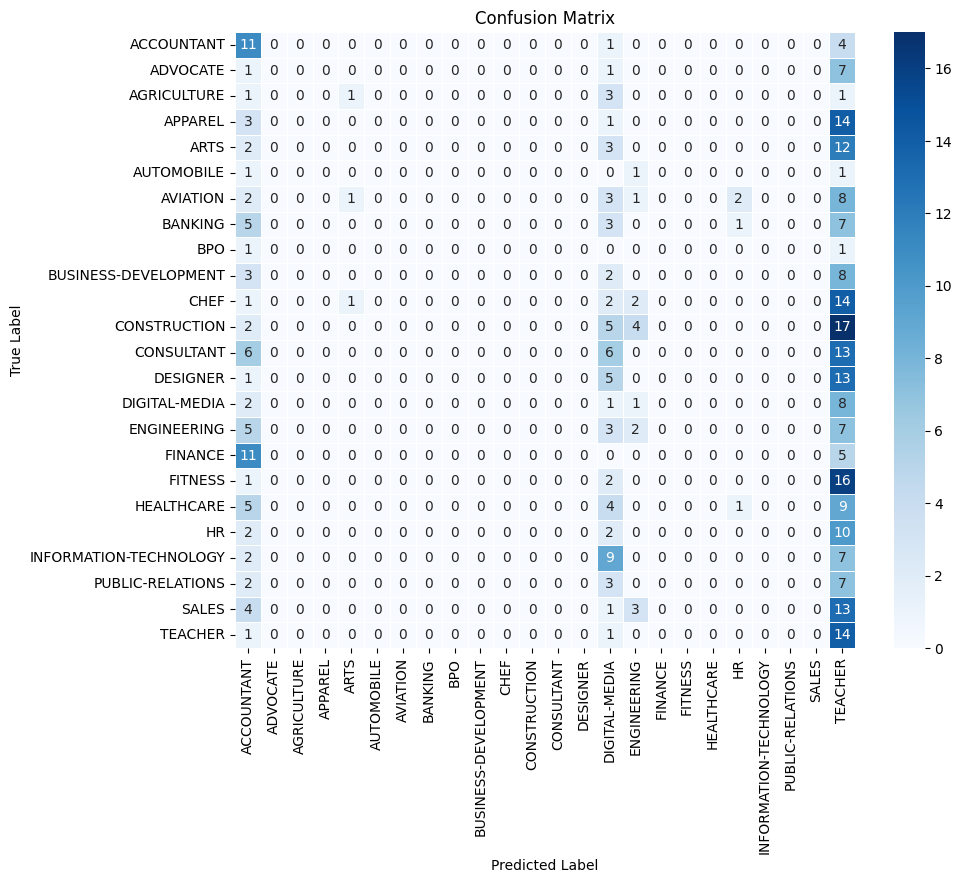

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already computed
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert to DataFrame for better visualization with seaborn
import pandas as pd

# Create a DataFrame with the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
label_map = {label: idx for idx, label in enumerate(np.unique(y))}

# Save the label map
with open('lbl_map.pkl', 'wb') as f:
    joblib.dump(label_map, f)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

# Load the dataset (assuming the CSV file contains 'Resume_str' and 'Category')
df = pd.read_csv('dataset/Resume/Resume.csv')

# Preprocess the data
X = df['Resume_str'].values
y = df['Category'].values

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=200)  # Adjust maxlen as needed

# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_int = np.array([label_map[label] for label in y])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_int, test_size=0.3, random_state=42)

# Define the deep learning model
def create_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        LSTM(128, return_sequences=True),
        GlobalMaxPool1D(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(len(label_map), activation='softmax')  # Output layer size based on the number of categories
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(vocab_size=5000, embedding_dim=128, input_length=200)
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# Save the model and tokenizer
model.save('deep_learning_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    joblib.dump(tokenizer, f)

# Save the label map
with open('label_map.pkl', 'wb') as f:
    joblib.dump(label_map, f)


2024-08-22 20:02:20.672364: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 20:02:20.762905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 20:02:20.764459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 20:02:22.522194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-22 20:02:31.135063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat

Epoch 1/100


2024-08-22 20:02:31.785443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:02:31.789143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:02:31.792146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/55 [==============================] - ETA: 0s - loss: 3.1713 - accuracy: 0.0483

2024-08-22 20:02:51.801371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:02:51.804798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:02:51.807353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/55 [==============================] - 23s 355ms/step - loss: 3.1713 - accuracy: 0.0483 - val_loss: 3.1510 - val_accuracy: 0.1005
Epoch 2/100
55/55 [==============================] - 15s 279ms/step - loss: 3.0818 - accuracy: 0.0915 - val_loss: 3.0015 - val_accuracy: 0.1180
Epoch 3/100
55/55 [==============================] - 14s 263ms/step - loss: 2.8756 - accuracy: 0.1203 - val_loss: 2.8209 - val_accuracy: 0.1340
Epoch 4/100
55/55 [==============================] - 15s 269ms/step - loss: 2.5188 - accuracy: 0.2117 - val_loss: 2.7361 - val_accuracy: 0.2118
Epoch 5/100
55/55 [==============================] - 14s 250ms/step - loss: 2.1018 - accuracy: 0.3470 - val_loss: 2.7971 - val_accuracy: 0.2078
Epoch 6/100
55/55 [==============================] - 15s 270ms/step - loss: 1.6779 - accuracy: 0.4580 - val_loss: 2.9100 - val_accuracy: 0.2252
Epoch 7/100
55/55 [==============================] - 14s 261ms/step - loss: 1.3169 - accuracy: 0.5834 - val_loss: 3.3270 - val_accuracy: 0.2440
Epoc